# Cargar

## Biblioteca

In [11]:
import optuna
import pandas as pd  # load and manipulate data and for One-Hot Encoding
import numpy as np  # calculate the mean and standard deviation
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb  # XGBoost stuff
from sklearn.model_selection import train_test_split  # split data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer  # for scoring during
from sklearn.model_selection import GridSearchCV  # cross validation
from sklearn.metrics import confusion_matrix  # creates a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay  # draws a confusion matrix
from sklearn.preprocessing import OneHotEncoder  # Más explícito para encoding
from sklearn.metrics import classification_report

from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
from itertools import product

## Data Frame

In [2]:
df_base = pd.read_csv('base_rm.csv', encoding='utf-8', low_memory=False)
df_base = df_base.reset_index(drop=True)
df_base['Date'] = pd.to_datetime(df_base['Date'])

df_base = df_base.sort_values('Date')

filas, columnas = df_base.shape
print(f"Número de filas: {filas}")
print(f"Número de columnas: {columnas}")

Número de filas: 9984660
Número de columnas: 18


In [3]:
df_base.head()

,Date,Year,Month,Day,Hour,Nombre_Oficina_Arp,Nombre_Municipio_IPS2,MUNICIPIO,Nombre_Tipo_Atencion_Arp,Cantidad,TENDENCIA,lag_1,lag_7,mm_7,mm_12,mm_30,delta_lag,std_7
7521029,2019-01-01,2019,1,1,0,OFICINA BOGOTA,MEDELLIN,FUNZA,QUIRURGICO HOSPITALARIO,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6131996,2019-01-01,2019,1,1,0,OFICINA CALI,MEDELLIN,PRADERA,QUIRURGICO AMBULATORIO,1,0,1.0,NaN,NaN,NaN,NaN,0.0,NaN
6131995,2019-01-01,2019,1,1,0,OFICINA MEDELLIN,MEDELLIN,MEDELLIN,QUIRURGICO AMBULATORIO,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8925611,2019-01-01,2019,1,1,0,OFICINA PEREIRA,PEREIRA,PEREIRA-RISARALDA,QUIRURGICO HOSPITALARIO,1,0,1.0,NaN,NaN,NaN,NaN,0.0,NaN
8925610,2019-01-01,2019,1,1,0,OFICINA MANIZALES,PEREIRA,MARMATO,QUIRURGICO HOSPITALARIO,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Formato

## Encoded

In [4]:
df_encoded_base = pd.get_dummies(df_base, columns=['Nombre_Oficina_Arp', 'Nombre_Tipo_Atencion_Arp'])

lip = LabelEncoder()
lm = LabelEncoder()

df_encoded_base['Nombre_Municipio_IPS2'] = lip.fit_transform(df_base['Nombre_Municipio_IPS2'])
df_encoded_base['MUNICIPIO'] = lm.fit_transform(df_base['MUNICIPIO'])

municipio_ips_dict = dict(zip(lip.transform(lip.classes_), lip.classes_))
municipio_dict = dict(zip(lm.transform(lm.classes_), lm.classes_))

df_encoded_base.head()


,Date,Year,Month,Day,Hour,Nombre_Municipio_IPS2,MUNICIPIO,Cantidad,TENDENCIA,lag_1,...,Nombre_Oficina_Arp_OFICINA MANIZALES,Nombre_Oficina_Arp_OFICINA MEDELLIN,Nombre_Oficina_Arp_OFICINA PEREIRA,Nombre_Tipo_Atencion_Arp_ALTA INMEDIATA,Nombre_Tipo_Atencion_Arp_AMBULATORIA,Nombre_Tipo_Atencion_Arp_HOSPITALARIA,Nombre_Tipo_Atencion_Arp_ODONTOLOGIA,Nombre_Tipo_Atencion_Arp_QUIRURGICO AMBULATORIO,Nombre_Tipo_Atencion_Arp_QUIRURGICO HOSPITALARIO,Nombre_Tipo_Atencion_Arp_UNIDAD DE CUIDADOS INTENSIVOS
7521029,2019-01-01,2019,1,1,0,80,354,1,0,NaN,...,False,False,False,False,False,False,False,False,True,False
6131996,2019-01-01,2019,1,1,0,80,684,1,0,1.0,...,False,False,False,False,False,False,False,True,False,False
6131995,2019-01-01,2019,1,1,0,80,547,1,0,NaN,...,False,True,False,False,False,False,False,True,False,False
8925611,2019-01-01,2019,1,1,0,97,659,1,0,1.0,...,False,False,True,False,False,False,False,False,True,False
8925610,2019-01-01,2019,1,1,0,97,542,1,0,NaN,...,True,False,False,False,False,False,False,False,True,False


## Division

In [5]:
df_encoded_base.tail(1)

,Date,Year,Month,Day,Hour,Nombre_Municipio_IPS2,MUNICIPIO,Cantidad,TENDENCIA,lag_1,...,Nombre_Oficina_Arp_OFICINA MANIZALES,Nombre_Oficina_Arp_OFICINA MEDELLIN,Nombre_Oficina_Arp_OFICINA PEREIRA,Nombre_Tipo_Atencion_Arp_ALTA INMEDIATA,Nombre_Tipo_Atencion_Arp_AMBULATORIA,Nombre_Tipo_Atencion_Arp_HOSPITALARIA,Nombre_Tipo_Atencion_Arp_ODONTOLOGIA,Nombre_Tipo_Atencion_Arp_QUIRURGICO AMBULATORIO,Nombre_Tipo_Atencion_Arp_QUIRURGICO HOSPITALARIO,Nombre_Tipo_Atencion_Arp_UNIDAD DE CUIDADOS INTENSIVOS
1551507,2024-12-31 22:35:00,2024,12,31,22,15,547,1,52606,1.0,...,False,True,False,False,False,False,False,False,True,False


In [6]:
df_encoded_base.dtypes

Date                                                      datetime64[ns]
Year                                                               int64
Month                                                              int64
Day                                                                int64
Hour                                                               int64
Nombre_Municipio_IPS2                                              int32
MUNICIPIO                                                          int32
Cantidad                                                           int64
TENDENCIA                                                          int64
lag_1                                                            float64
lag_7                                                            float64
mm_7                                                             float64
mm_12                                                            float64
mm_30                                              

In [7]:
#Dividir datos
cutoff = pd.to_datetime('2024-12-31')
train = df_encoded_base[df_encoded_base['Date'] <= cutoff]

X_train = train.drop(columns=['Date', 'Cantidad'])
y_train = train['Cantidad']

features = X_train.columns.tolist()

#Estructura DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

print("X shape:", df_encoded_base.shape)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X shape: (9984660, 31)
X_train shape: (9982042, 29)
y_train shape: (9982042,)


In [8]:
X_train.dtypes

Year                                                        int64
Month                                                       int64
Day                                                         int64
Hour                                                        int64
Nombre_Municipio_IPS2                                       int32
MUNICIPIO                                                   int32
TENDENCIA                                                   int64
lag_1                                                     float64
lag_7                                                     float64
mm_7                                                      float64
mm_12                                                     float64
mm_30                                                     float64
delta_lag                                                 float64
std_7                                                     float64
Nombre_Oficina_Arp_OFICINA BARRANQUILLA                      bool
Nombre_Ofi

## Modelo

In [10]:
best_params = {'learning_rate': 0.1041632522057729, 
               'max_depth': 6, 
               'subsample': 0.9506239437939494, 
               'colsample_bytree': 0.9832575009920059, 
               'gamma': 0.009185962608650233, 
               'lambda': 0.7695030088742605, 
               'alpha': 0.0020379600947978494, 
               'n_estimators': 396}

params = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',  # o 'hist' si estás en CPU
    'predictor': 'gpu_predictor',
    'learning_rate': best_params['learning_rate'],
    'max_depth': best_params['max_depth'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'],
    'lambda': best_params['lambda'],
    'alpha': best_params['alpha'],
    'eval_metric': 'rmse'
}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_params['n_estimators'],  # ¡Importante!
    evals=[(dtrain, 'Train')],
    early_stopping_rounds=20,
    verbose_eval=True
)

c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:17:33] WARNING: D:\bld\xgboost-split_1703076510930\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\humbe\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:17:33] WARNING: D:\bld\xgboost-split_1703076510930\work\src\learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	Train-rmse:1.63964
[1]	Train-rmse:1.47020
[2]	Train-rmse:1.31856
[3]	Train-rmse:1.18282
[4]	Train-rmse:1.06138
[5]	Train-rmse:0.95279
[6]	Train-rmse:0.85563
[7]	Train-rmse:0.76885
[8]	Train-rmse:0.69122
[9]	Train-rmse:0.62977
[10]	Train-rmse:0.56727
[11]	Train-rmse:0.51149
[12]	Train-rmse:0.46186
[13]	Train-rmse:0.41758
[14]	Train-rmse:0.37816
[15]	Train-rmse:0.34331
[16]	Train-rmse:0.31259
[17]	Train-rmse:0.28541
[18]	Train-rmse:0.26087
[19]	Train-rmse:0.23986
[20]	Train-rmse:0.22347
[21]	Train-rmse:0.20705
[22]	Train-rmse:0.19279
[23]	Train-rmse:0.18050
[24]	Train-rmse:0.16945
[25]	Train-rmse:0.15945
[26]	Train-rmse:0.15158
[27]	Train-rmse:0.15112
[28]	Train-rmse:0.14412
[29]	Train-rmse:0.13759
[30]	Train-rmse:0.13248
[31]	Train-rmse:0.12832
[32]	Train-rmse:0.12438
[33]	Train-rmse:0.12127
[34]	Train-rmse:0.11769
[35]	Train-rmse:0.11519
[36]	Train-rmse:0.11317
[37]	Train-rmse:0.11296
[38]	Train-rmse:0.11060
[39]	Train-rmse:0.10852
[40]	Train-rmse:0.10677
[41]	Train-rmse:0.10537
[4

In [ ]:
#df_encoded_base.to_csv('base_2.csv', index=False, encoding='utf-8-sig')

# Prediccion

In [38]:
print(features)

['Year', 'Month', 'Day', 'Nombre_Municipio_IPS2', 'MUNICIPIO', 'Day_Week', 'TENDENCIA', 'lag_1', 'mm_7', 'mm_12', 'lag_7', 'delta_lag', 'std_7', 'Nombre_Oficina_Arp_OFICINA BARRANQUILLA', 'Nombre_Oficina_Arp_OFICINA BOGOTA', 'Nombre_Oficina_Arp_OFICINA BUCARAMANGA', 'Nombre_Oficina_Arp_OFICINA CALI', 'Nombre_Oficina_Arp_OFICINA CARTAGENA', 'Nombre_Oficina_Arp_OFICINA MANIZALES', 'Nombre_Oficina_Arp_OFICINA MEDELLIN', 'Nombre_Oficina_Arp_OFICINA PEREIRA', 'Nombre_Tipo_Atencion_Arp_ALTA INMEDIATA', 'Nombre_Tipo_Atencion_Arp_AMBULATORIA', 'Nombre_Tipo_Atencion_Arp_HOSPITALARIA', 'Nombre_Tipo_Atencion_Arp_ODONTOLOGIA', 'Nombre_Tipo_Atencion_Arp_QUIRURGICO AMBULATORIO', 'Nombre_Tipo_Atencion_Arp_QUIRURGICO HOSPITALARIO', 'Nombre_Tipo_Atencion_Arp_UNIDAD DE CUIDADOS INTENSIVOS']


In [ ]:
df_encoded_base = pd.read_csv('base_2.csv', encoding='utf-8-sig', low_memory=False)

In [19]:
df_encoded_base.head()

,Date,Year,Month,Day,Hour,Nombre_Municipio_IPS2,MUNICIPIO,Cantidad,TENDENCIA,lag_1,...,Nombre_Oficina_Arp_OFICINA MANIZALES,Nombre_Oficina_Arp_OFICINA MEDELLIN,Nombre_Oficina_Arp_OFICINA PEREIRA,Nombre_Tipo_Atencion_Arp_ALTA INMEDIATA,Nombre_Tipo_Atencion_Arp_AMBULATORIA,Nombre_Tipo_Atencion_Arp_HOSPITALARIA,Nombre_Tipo_Atencion_Arp_ODONTOLOGIA,Nombre_Tipo_Atencion_Arp_QUIRURGICO AMBULATORIO,Nombre_Tipo_Atencion_Arp_QUIRURGICO HOSPITALARIO,Nombre_Tipo_Atencion_Arp_UNIDAD DE CUIDADOS INTENSIVOS
7521029,2019-01-01,2019,1,1,0,80,354,1,0,NaN,...,False,False,False,False,False,False,False,False,True,False
6131996,2019-01-01,2019,1,1,0,80,684,1,0,1.0,...,False,False,False,False,False,False,False,True,False,False
6131995,2019-01-01,2019,1,1,0,80,547,1,0,NaN,...,False,True,False,False,False,False,False,True,False,False
8925611,2019-01-01,2019,1,1,0,97,659,1,0,1.0,...,False,False,True,False,False,False,False,False,True,False
8925610,2019-01-01,2019,1,1,0,97,542,1,0,NaN,...,True,False,False,False,False,False,False,False,True,False


In [20]:

fechas_2025 = pd.date_range(start="2025-01-01", end="2025-12-31", freq="D")

def generar_combinaciones(df):
    municipios = df["Nombre_Municipio_IPS2"].unique()
    oficinas = [col for col in df.columns if col.startswith("Nombre_Oficina_Arp_")]
    tipos_atencion = [col for col in df.columns if col.startswith("Nombre_Tipo_Atencion_Arp_")]
    return list(product(municipios, oficinas, tipos_atencion)), oficinas, tipos_atencion

def valores_fijos_promedio(df):
    return {
        "TENDENCIA": df["TENDENCIA"].mean(),
        "lag_1": df["lag_1"].mean(),
        "lag_7": df["lag_7"].mean(),
        "mm_7": df["mm_7"].mean(),
        "mm_12": df["mm_12"].mean(),
        "mm_30": df["mm_30"].mean(),
        "delta_lag": df["delta_lag"].mean(),
        "std_7": df["std_7"].mean(),
        "Hour": 0
    }

def predecir_combinacion(model, municipio, oficina_col, tipo_col, fechas, valores_fijos, X_cols, oficinas, tipos_atencion):
    df_temp = pd.DataFrame({
        "Date": fechas,
        "Year": fechas.year,
        "Month": fechas.month,
        "Day": fechas.day,
        "Hour": valores_fijos["Hour"],
        "Nombre_Municipio_IPS2": municipio,
        "MUNICIPIO": municipio,
    })

    # Agregar columnas fijas
    for col, val in valores_fijos.items():
        if col not in df_temp.columns:
            df_temp[col] = val

    # Inicializar todas las columnas dummy en 0
    for col in oficinas + tipos_atencion:
        df_temp[col] = 0

    # Activar la combinación actual
    df_temp[oficina_col] = 1
    df_temp[tipo_col] = 1

    # Reordenar columnas según el modelo
    X_pred = df_temp[X_cols]
    dmatrix = xgb.DMatrix(X_pred)

    # Realizar predicción
    df_temp["Pred_Cantidad"] = model.predict(dmatrix)

    # Agregar nombre descriptivo para oficina y tipo
    df_temp["Oficina"] = oficina_col.replace("Nombre_Oficina_Arp_", "")
    df_temp["Tipo_Atencion"] = tipo_col.replace("Nombre_Tipo_Atencion_Arp_", "")

    return df_temp[["Date", "Nombre_Municipio_IPS2", "Oficina", "Tipo_Atencion", "Pred_Cantidad"]]

# Paso 5: Función principal que corre todo en paralelo
def prediccion(df_base, model, n_jobs):
    combinaciones, oficinas, tipos_atencion = generar_combinaciones(df_base)
    valores_fijos = valores_fijos_promedio(df_base)
    X_cols = [col for col in df_base.columns if col not in ["Cantidad", "Date"]]

    resultados = Parallel(n_jobs=n_jobs)(
        delayed(predecir_combinacion)(model, municipio, oficina, tipo, fechas_2025, 
                                      valores_fijos, X_cols, oficinas, tipos_atencion)
        for municipio, oficina, tipo in combinaciones
    )

    return pd.concat(resultados, ignore_index=True)


In [21]:
df_pred = prediccion(df_encoded_base, model,n_jobs=15)

In [22]:
df_pred.head()

,Date,Nombre_Municipio_IPS2,Oficina,Tipo_Atencion,Pred_Cantidad
0,2025-01-01,80,OFICINA BARRANQUILLA,ALTA INMEDIATA,0.99628
1,2025-01-02,80,OFICINA BARRANQUILLA,ALTA INMEDIATA,0.99628
2,2025-01-03,80,OFICINA BARRANQUILLA,ALTA INMEDIATA,0.99628
3,2025-01-04,80,OFICINA BARRANQUILLA,ALTA INMEDIATA,0.99628
4,2025-01-05,80,OFICINA BARRANQUILLA,ALTA INMEDIATA,0.99628


In [24]:
filas, columnas = df_pred.shape
print(f"Número de filas: {filas}")
print(f"Número de columnas: {columnas}")

Número de filas: 3331720
Número de columnas: 5


In [ ]:
df_pred.to_csv('prediccion_1.csv', inedex=False, encoding='utf-8')

# Resultado

In [25]:
df_label = df_pred.copy()

df_label['Nombre_Municipio_IPS2'] = df_label['Nombre_Municipio_IPS2'].map(municipio_ips_dict)

df_label.head()

,Date,Nombre_Municipio_IPS2,Oficina,Tipo_Atencion,Pred_Cantidad
0,2025-01-01,MEDELLIN,OFICINA BARRANQUILLA,ALTA INMEDIATA,0.99628
1,2025-01-02,MEDELLIN,OFICINA BARRANQUILLA,ALTA INMEDIATA,0.99628
2,2025-01-03,MEDELLIN,OFICINA BARRANQUILLA,ALTA INMEDIATA,0.99628
3,2025-01-04,MEDELLIN,OFICINA BARRANQUILLA,ALTA INMEDIATA,0.99628
4,2025-01-05,MEDELLIN,OFICINA BARRANQUILLA,ALTA INMEDIATA,0.99628


In [26]:
df_pred_reco = df_label.copy()

In [33]:
Atencion = df_pred_reco['Tipo_Atencion'].value_counts().reset_index()
Atencion.columns = ['Tipo_Atencion NIT', 'Frecuencia']

print(Atencion)

               Tipo_Atencion NIT  Frecuencia
0                 ALTA INMEDIATA      475960
1                    AMBULATORIA      475960
2                   HOSPITALARIA      475960
3                    ODONTOLOGIA      475960
4         QUIRURGICO AMBULATORIO      475960
5        QUIRURGICO HOSPITALARIO      475960
6  UNIDAD DE CUIDADOS INTENSIVOS      475960


In [27]:
df_pred_reco.columns

Index(['Date', 'Nombre_Municipio_IPS2', 'Oficina', 'Tipo_Atencion',
       'Pred_Cantidad'],
      dtype='object')

In [56]:
df_pred_reco = df_pred_reco[['Date', 'Year', 'Month', 'Day', 'Day_Week', 'TENDENCIA', 
                             'Nombre_Oficina_Arp', 'Nombre_Municipio_IPS2', 'Municipio', 
                             'Nombre_Tipo_Atencion_Arp', 'Cantidad']]

df_pred_reco.head()

,Date,Year,Month,Day,Day_Week,TENDENCIA,Nombre_Oficina_Arp,Nombre_Municipio_IPS2,Municipio,Nombre_Tipo_Atencion_Arp,Cantidad
0,2025-01-01,2025,1,1,2,2192,OFICINA MEDELLIN,MEDELLIN,BOGOTA,AMBULATORIA,1.000272
1,2025-01-02,2025,1,2,3,2193,OFICINA MEDELLIN,MEDELLIN,BOGOTA,AMBULATORIA,1.000272
2,2025-01-03,2025,1,3,4,2194,OFICINA MEDELLIN,MEDELLIN,BOGOTA,AMBULATORIA,1.000272
3,2025-01-04,2025,1,4,5,2195,OFICINA MEDELLIN,MEDELLIN,BOGOTA,AMBULATORIA,1.002856
4,2025-01-05,2025,1,5,6,2196,OFICINA BOGOTA,MEDELLIN,BOGOTA,AMBULATORIA,0.998839


In [59]:
df_pred_reco.to_csv('prediccion_reco.csv', index=False, encoding='utf-8')

## Grafica

### Diaria

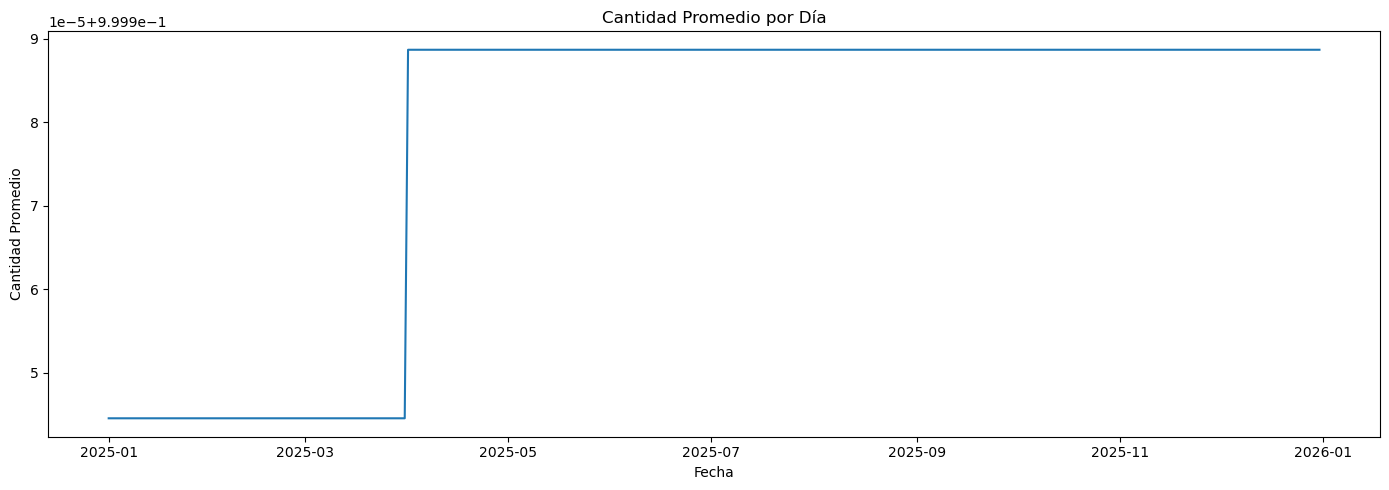

In [29]:
# Asegurar tipo datetime
df_pred_reco['Date'] = pd.to_datetime(df_pred_reco['Date'])

# Agrupar por fecha
media_diaria = df_pred_reco.groupby('Date')['Pred_Cantidad'].mean().reset_index()

# Gráfico
plt.figure(figsize=(14, 5))
sns.lineplot(data=media_diaria, x='Date', y='Pred_Cantidad')
plt.title('Cantidad Promedio por Día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Promedio')
plt.tight_layout()
plt.show()

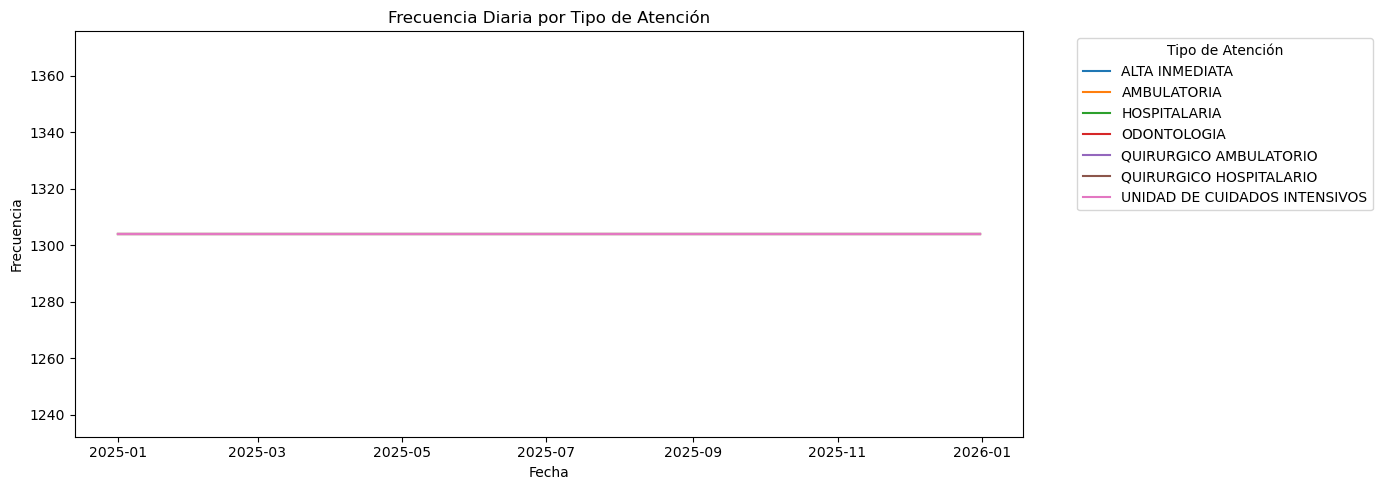

In [31]:
frecuencia_tipo_diaria = df_pred_reco.groupby(['Date', 'Tipo_Atencion']).size().reset_index(name='Frecuencia')

plt.figure(figsize=(14, 5))
sns.lineplot(data=frecuencia_tipo_diaria, x='Date', y='Frecuencia', hue='Tipo_Atencion')
plt.title('Frecuencia Diaria por Tipo de Atención')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo de Atención', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

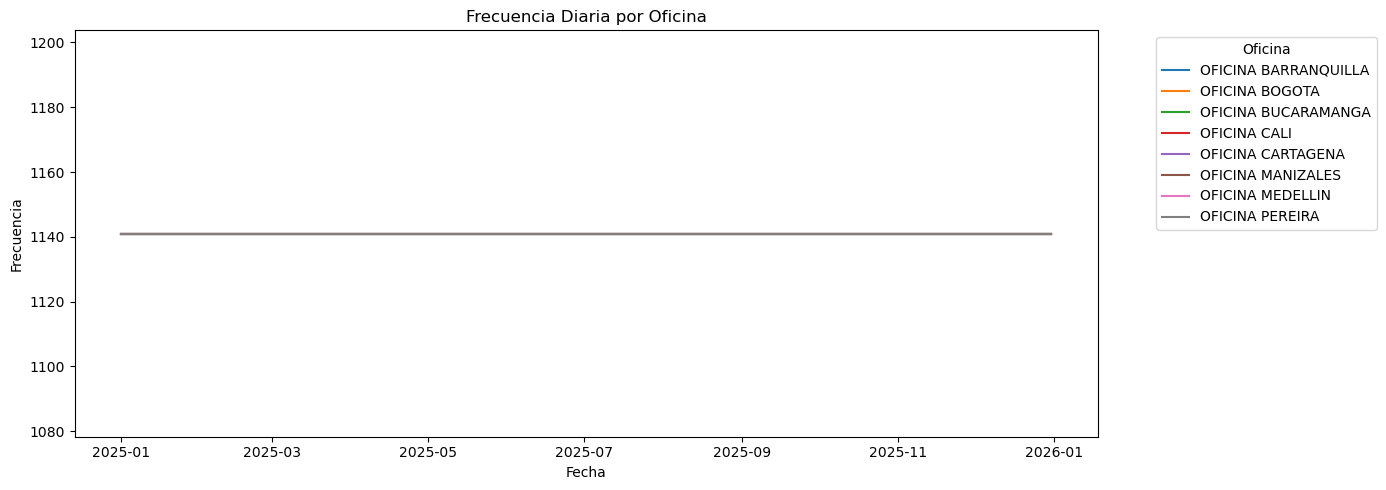

In [35]:
frecuencia_oficina_diaria = df_pred_reco.groupby(['Date', 'Oficina']).size().reset_index(name='Frecuencia')

plt.figure(figsize=(14, 5))
sns.lineplot(data=frecuencia_oficina_diaria, x='Date', y='Frecuencia', hue='Oficina')
plt.title('Frecuencia Diaria por Oficina')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.legend(title='Oficina', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Mensual

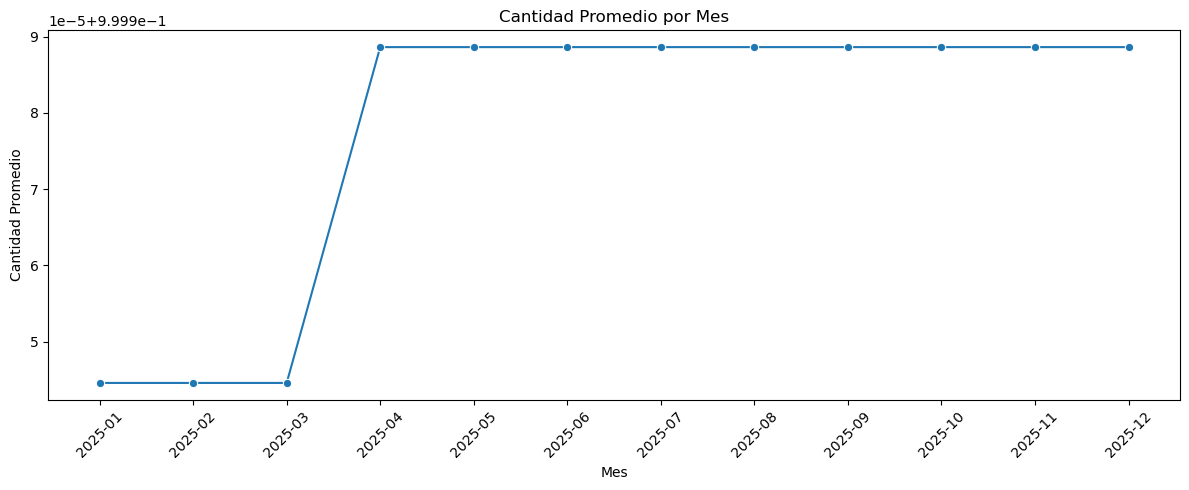

In [36]:
# Asegurar que la columna de fecha es datetime
df_pred_reco['Date'] = pd.to_datetime(df_pred_reco['Date'])

# Crear columna año-mes
df_pred_reco['AñoMes'] = df_pred_reco['Date'].dt.to_period('M')

# Agrupar y calcular la media mensual
media_mensual = df_pred_reco.groupby('AñoMes')['Pred_Cantidad'].mean().reset_index()
media_mensual['AñoMes'] = media_mensual['AñoMes'].astype(str)

# Gráfico
plt.figure(figsize=(12, 5))
sns.lineplot(data=media_mensual, x='AñoMes', y='Pred_Cantidad', marker='o')
plt.title('Cantidad Promedio por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad Promedio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


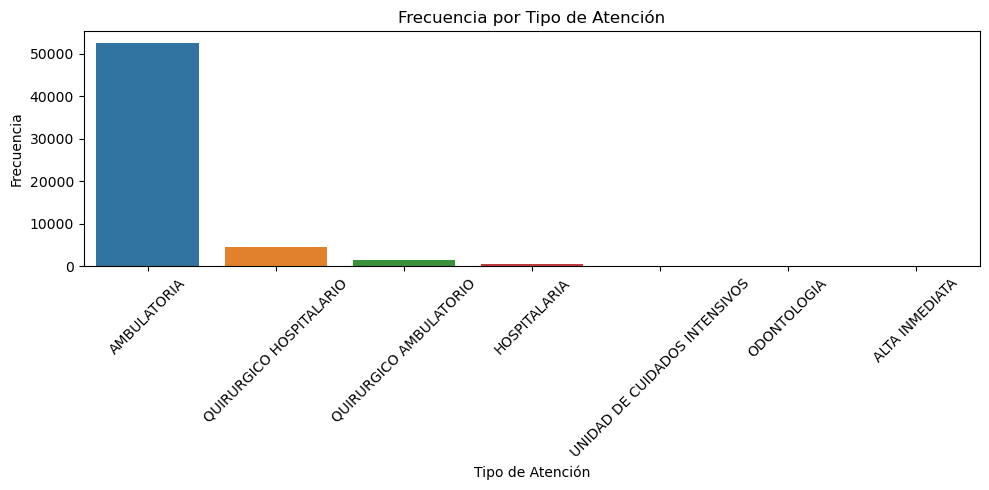

In [ ]:
frecuencia_tipo = df_pred_reco['Tipo_Atencion_Arp'].value_counts().reset_index()
frecuencia_tipo.columns = ['Tipo de Atención', 'Frecuencia']

plt.figure(figsize=(10, 5))
sns.barplot(data=frecuencia_tipo, x='Tipo de Atención', y='Frecuencia')
plt.title('Frecuencia por Tipo de Atención')
plt.xlabel('Tipo de Atención')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


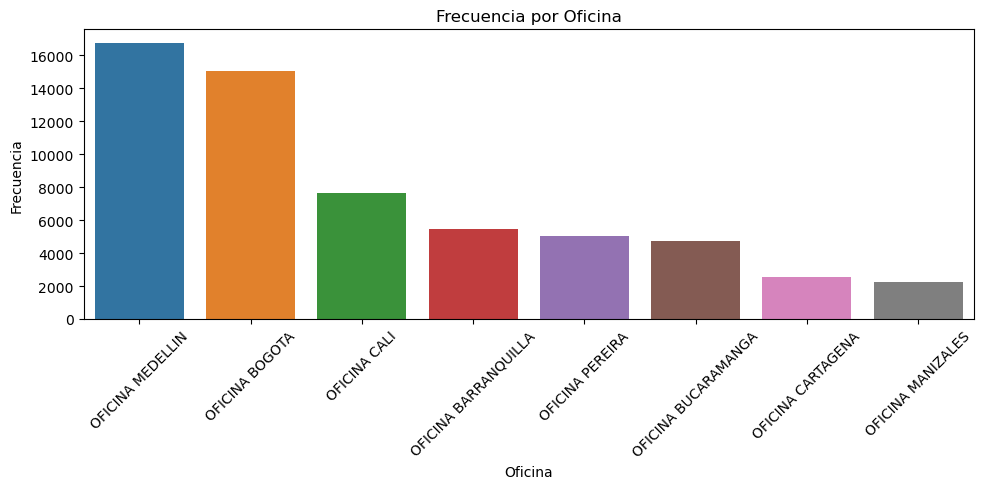

In [62]:
frecuencia_oficina = df_pred_reco['Nombre_Oficina_Arp'].value_counts().reset_index()
frecuencia_oficina.columns = ['Oficina', 'Frecuencia']

plt.figure(figsize=(10, 5))
sns.barplot(data=frecuencia_oficina, x='Oficina', y='Frecuencia')
plt.title('Frecuencia por Oficina')
plt.xlabel('Oficina')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
